# Bitcoin Price Prediction Using Machine Learning

In this notebook, we will use machine learning techniques to predict whether the price of Bitcoin will increase or decrease based on historical data. We will:
- Load and preprocess the data
- Explore the data through visualizations
- Train and evaluate various machine learning models
- Analyze the performance of the models using metrics like ROC-AUC.


### Import Libraries

In [38]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
import warnings

warnings.filterwarnings('ignore')


In [39]:
# Load Dataset
df = pd.read_csv('Data/BTC-USD (2014-2024).csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,18-09-2014,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
1,19-09-2014,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2,20-09-2014,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
3,21-09-2014,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0
4,22-09-2014,399.100006,406.915985,397.130005,402.152008,402.152008,24127600.0


In [40]:
df.shape

(3411, 7)

In [41]:
# Cell 4: Display Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3411 entries, 0 to 3410
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3411 non-null   object 
 1   Open       3411 non-null   float64
 2   High       3411 non-null   float64
 3   Low        3411 non-null   float64
 4   Close      3411 non-null   float64
 5   Adj Close  3411 non-null   float64
 6   Volume     3411 non-null   float64
dtypes: float64(6), object(1)
memory usage: 186.7+ KB


In [42]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3411.000000,3411.000000,3411.000000,3411.000000,3411.000000,3.411000e+03
mean,14739.467044,15084.010403,14368.140797,14750.235819,14750.235819,1.663183e+10
std,16289.496856,16680.173273,15851.362284,16291.266521,16291.266521,1.907865e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,921.513000,932.895508,907.335998,921.689514,921.689514,1.681380e+08
50%,8286.879883,8458.453125,8105.252930,8277.009766,8277.009766,1.180170e+10
75%,24327.469730,24949.477540,23870.385740,24351.801760,24351.801760,2.698524e+10
max,67549.734380,68789.625000,66382.062500,67566.828130,67566.828130,3.509680e+11


In [43]:
# Preprocess Data
def preprocess_data(df):
    df = df.drop(['Adj Close'], axis=1)
    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['is_quarter_end'] = np.where(df['month'] % 3 == 0, 1, 0)
    df['open-close'] = df['Open'] - df['Close']
    df['low-high'] = df['Low'] - df['High']
    df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
    return df

df = preprocess_data(df)
df.head()

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end,open-close,low-high,target
0,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,2014,9,18,1,32.419983,-43.755981,0
1,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,2014,9,19,1,29.307007,-43.302978,1
2,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,2014,9,20,1,-14.230988,-33.412994,0
3,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,2014,9,21,1,9.263977,-19.244995,1
4,2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600.0,2014,9,22,1,-3.052002,-9.785980,1


### Explore Data

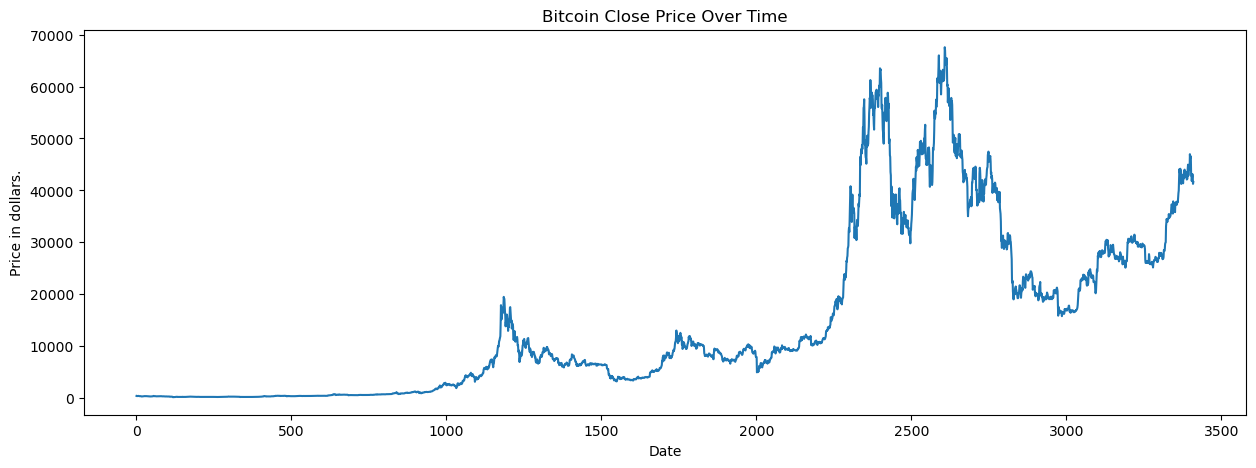

In [44]:
# Plot Close Price
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.title('Bitcoin Close Price Over Time')
plt.ylabel('Price in dollars.')
plt.xlabel('Date')
plt.show()

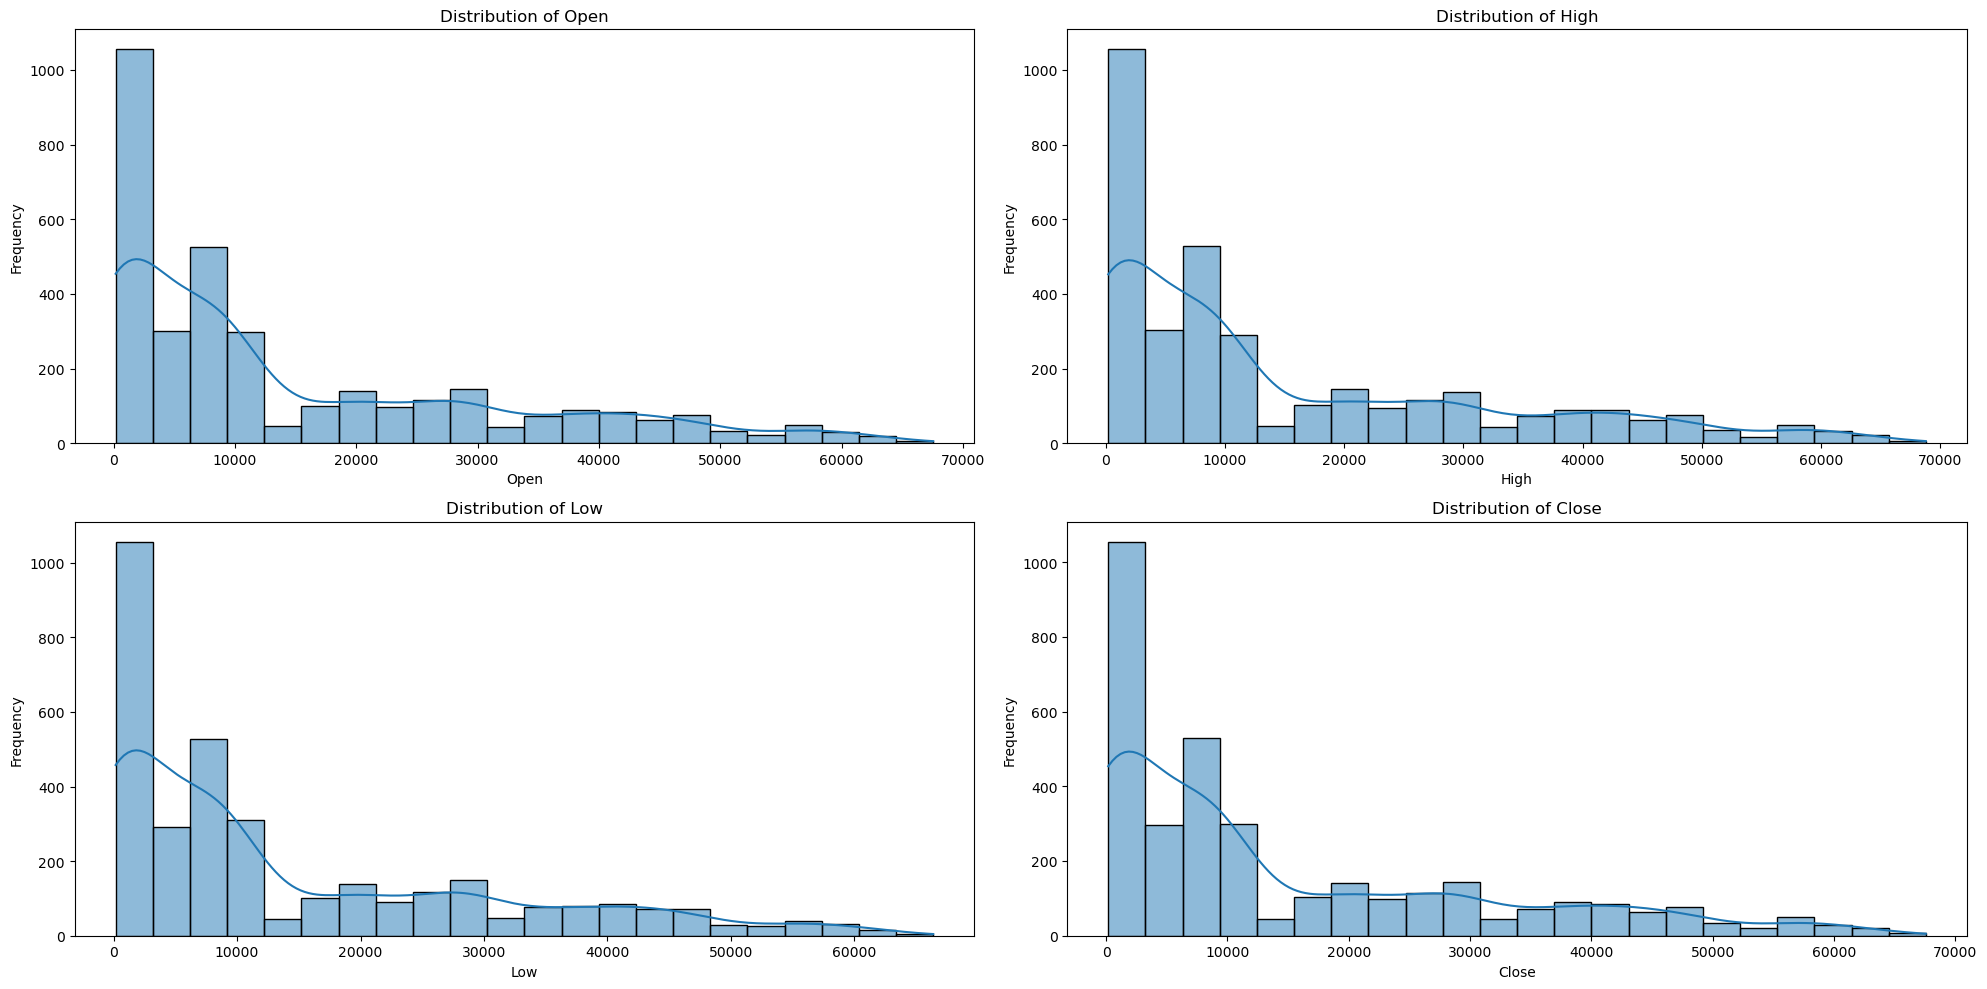

In [45]:
# Distribution of Features
features = ['Open', 'High', 'Low', 'Close']
plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sb.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

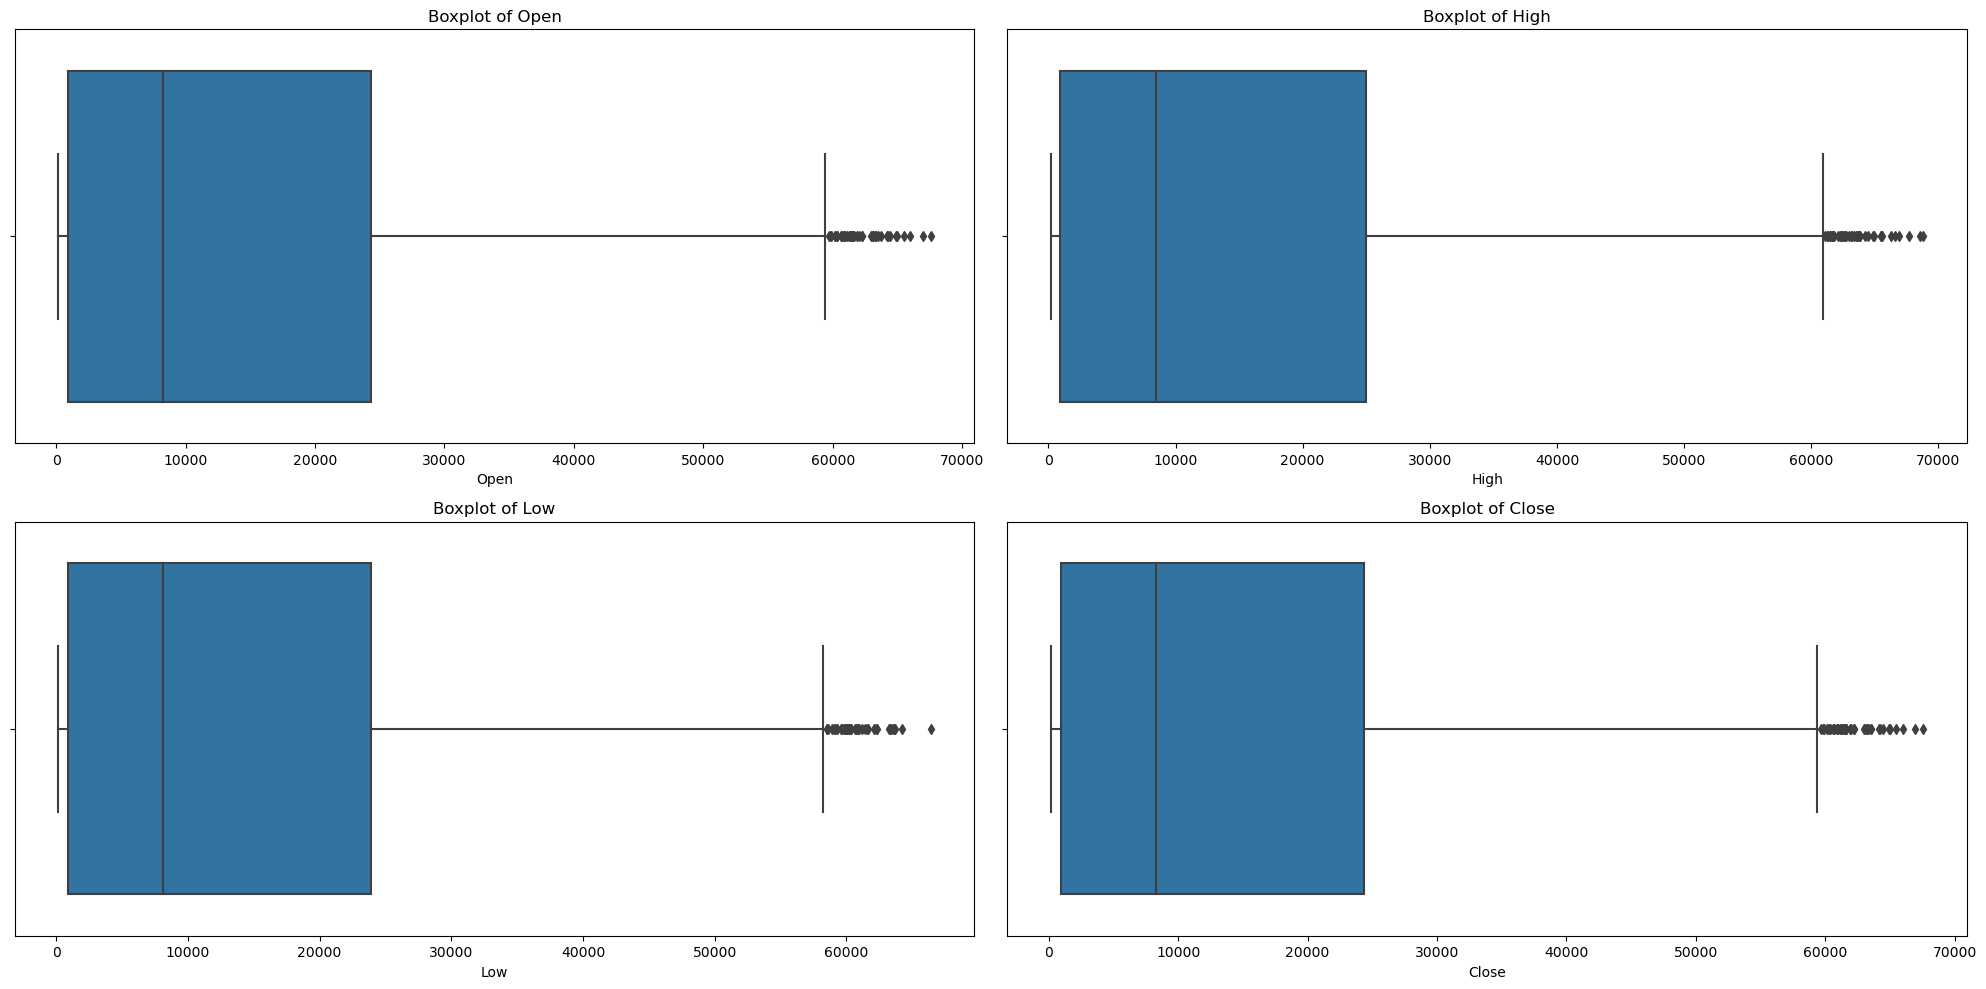

In [46]:
# Boxplot of Features
plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sb.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

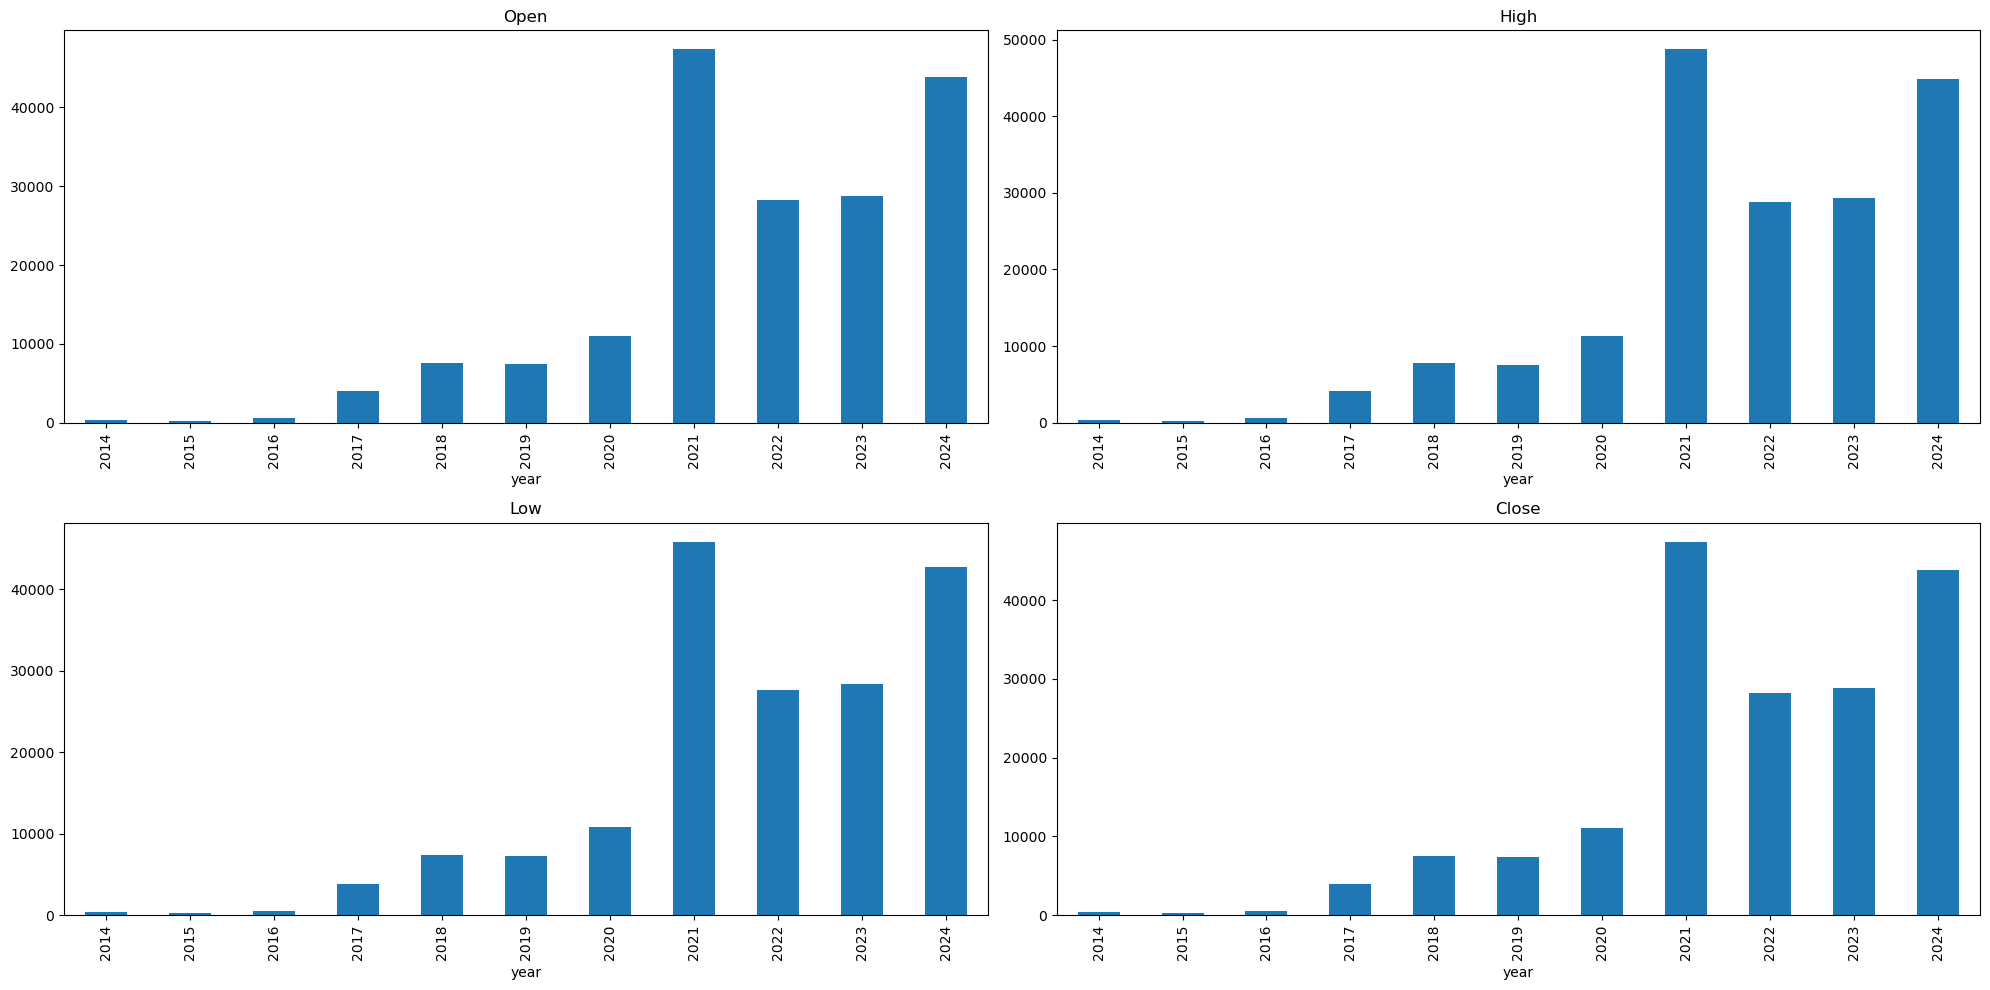

In [47]:
# Convert 'Date' column to datetime with dayfirst=True
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Extract the year from the 'Date' column
df['year'] = df['Date'].dt.year

# Group by year and calculate the mean for each year
data_grouped = df.groupby('year').mean()

# Plot the data
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
    data_grouped[col].plot.bar(ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

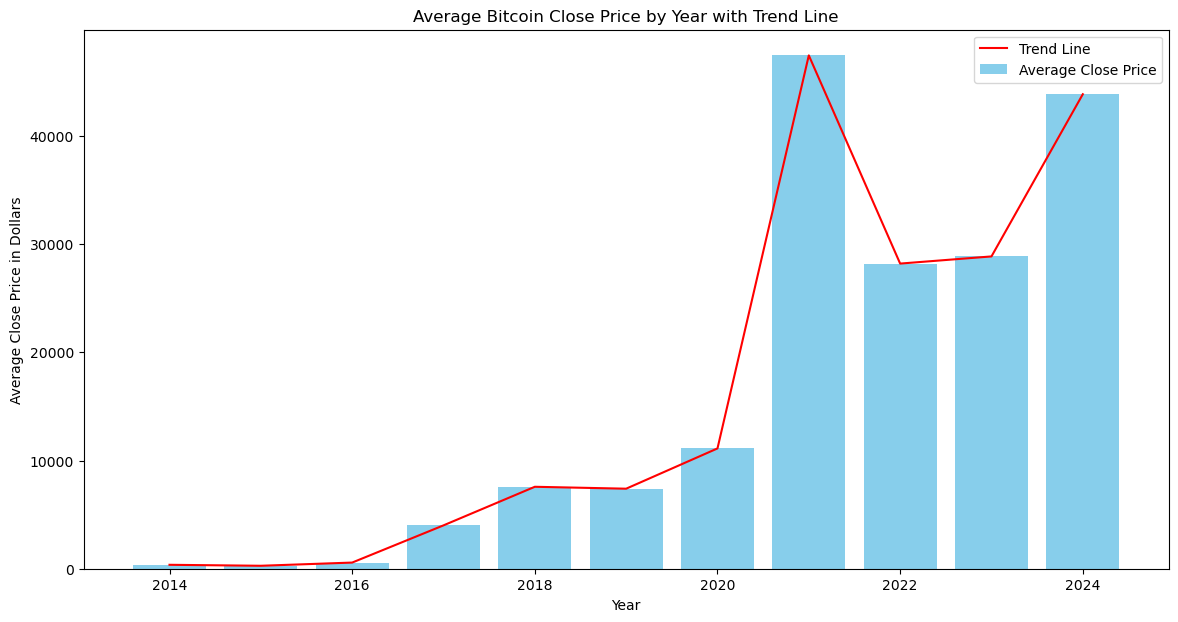

In [48]:
# Bar Plot with Curve
plt.figure(figsize=(14, 7))
df_grouped_by_year = df.groupby('year').mean()
plt.bar(df_grouped_by_year.index, df_grouped_by_year['Close'], color='skyblue', label='Average Close Price')
sb.lineplot(x=df_grouped_by_year.index, y=df_grouped_by_year['Close'], color='red', label='Trend Line')
plt.title('Average Bitcoin Close Price by Year with Trend Line')
plt.xlabel('Year')
plt.ylabel('Average Close Price in Dollars')
plt.legend()
plt.show()

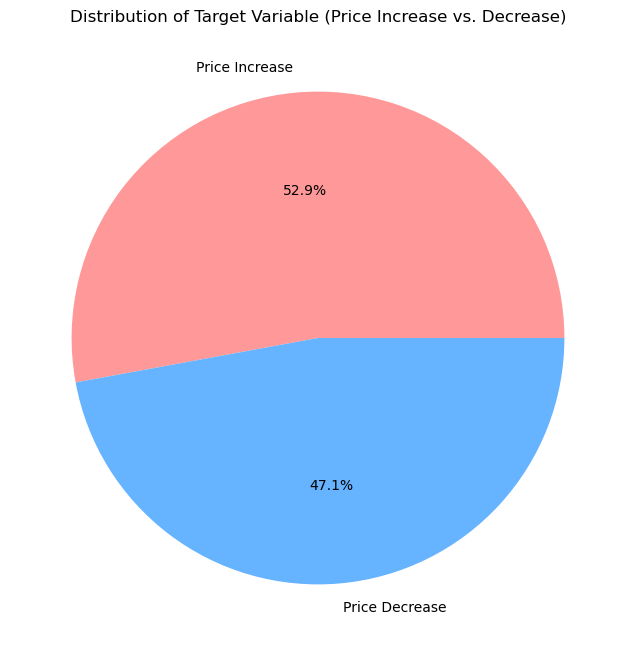

In [49]:
# Pie Chart of Target Distribution
plt.figure(figsize=(8, 8))
target_counts = df['target'].value_counts()
plt.pie(target_counts, labels=['Price Increase', 'Price Decrease'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Distribution of Target Variable (Price Increase vs. Decrease)')
plt.show()


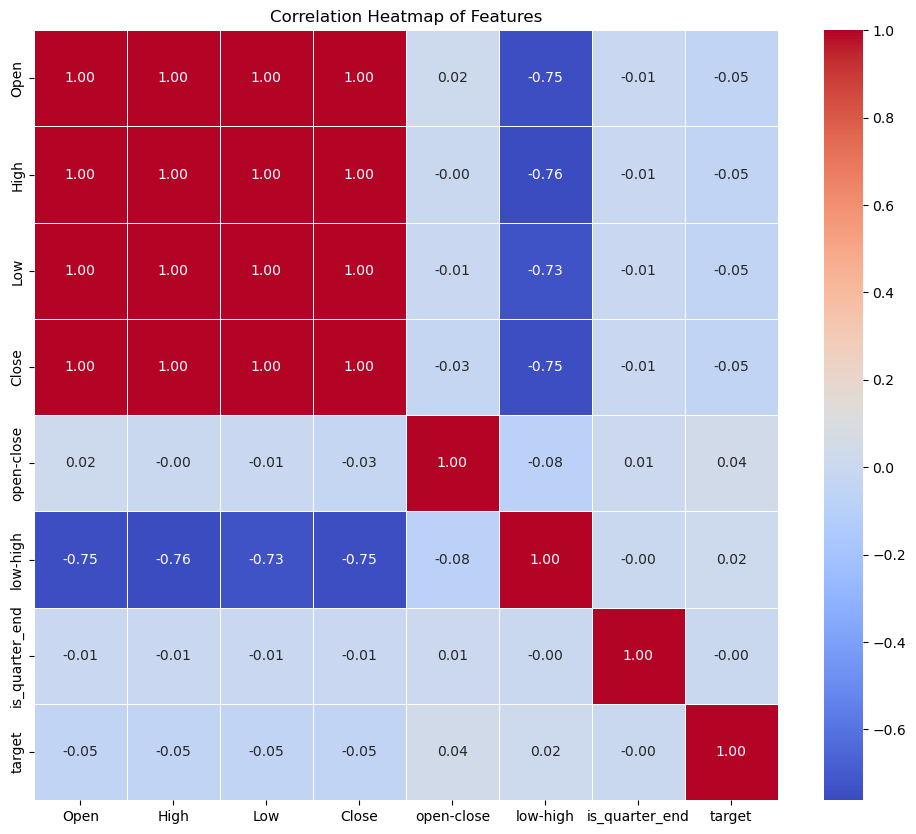

In [50]:
# Heatmap of Correlation Matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df[['Open', 'High', 'Low', 'Close', 'open-close', 'low-high', 'is_quarter_end', 'target']].corr()
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

In [51]:
# Prepare Features and Target
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.1, random_state=2022)
print(f'Training set shape: {X_train.shape}')
print(f'Validation set shape: {X_valid.shape}')

Training set shape: (3069, 3)
Validation set shape: (342, 3)


### Train Models

In [52]:
# Train Logistic Regression Model
log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)


LogisticRegression()

In [53]:
# Train SVC Model
svc = SVC(kernel='poly', probability=True)
svc.fit(X_train, Y_train)

SVC(kernel='poly', probability=True)

In [54]:
# Train XGBClassifier Model
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Evaluate Models

Logistic Regression Evaluation:
Training Accuracy: 0.5370452768976754
Validation Accuracy: 0.5160317895313784
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.10      0.16       164
           1       0.52      0.92      0.67       178

    accuracy                           0.52       342
   macro avg       0.52      0.51      0.42       342
weighted avg       0.52      0.52      0.43       342



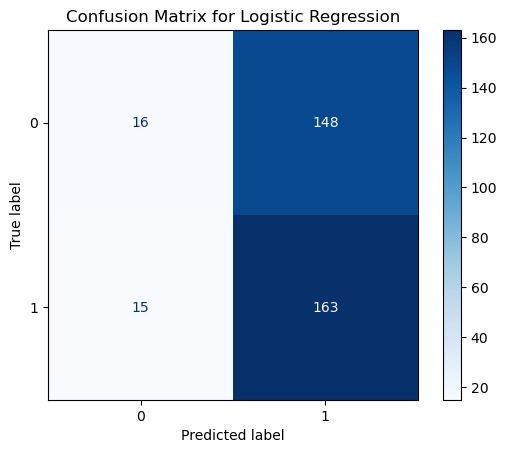

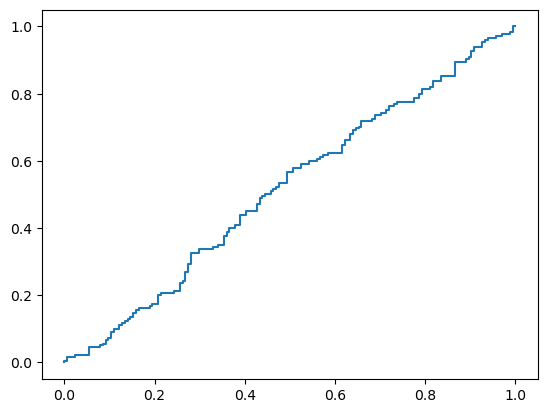

In [55]:
# Evaluate Logistic Regression
y_pred_log_reg = log_reg.predict(X_valid)
y_proba_log_reg = log_reg.predict_proba(X_valid)[:, 1]

print('Logistic Regression Evaluation:')
print('Training Accuracy:', metrics.roc_auc_score(Y_train, log_reg.predict_proba(X_train)[:, 1]))
print('Validation Accuracy:', metrics.roc_auc_score(Y_valid, y_proba_log_reg))
print('Classification Report:\n', classification_report(Y_valid, y_pred_log_reg))

# Confusion Matrix
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(Y_valid, y_pred_log_reg))
disp_log_reg.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# ROC Curve
fpr_log_reg, tpr_log_reg, _ = roc_curve(Y_valid, y_proba_log_reg)
auc_log_reg = roc_auc_score(Y_valid, y_proba_log_reg)
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression ROC curve (area = {auc_log_reg:.2f})')


SVC Evaluation:
Training Accuracy: 0.5381005473256395
Validation Accuracy: 0.5287064949301179
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.02      0.05       164
           1       0.52      0.98      0.68       178

    accuracy                           0.52       342
   macro avg       0.51      0.50      0.36       342
weighted avg       0.51      0.52      0.38       342



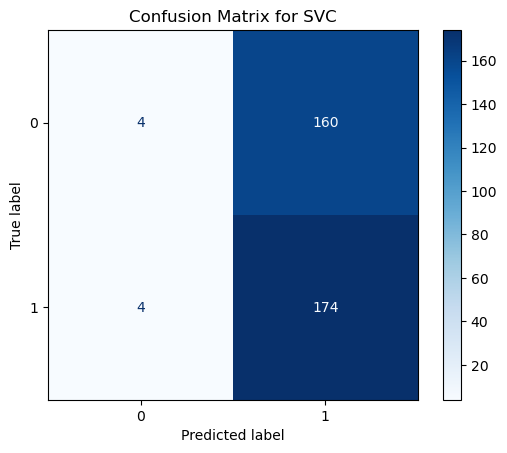

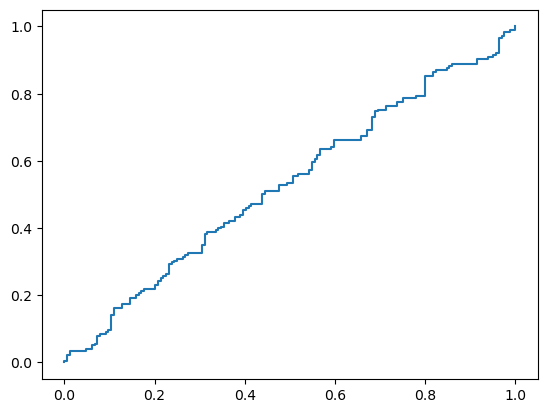

In [56]:
# Evaluate SVC
y_pred_svc = svc.predict(X_valid)
y_proba_svc = svc.predict_proba(X_valid)[:, 1]

print('SVC Evaluation:')
print('Training Accuracy:', metrics.roc_auc_score(Y_train, svc.predict_proba(X_train)[:, 1]))
print('Validation Accuracy:', metrics.roc_auc_score(Y_valid, y_proba_svc))
print('Classification Report:\n', classification_report(Y_valid, y_pred_svc))

# Confusion Matrix
disp_svc = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(Y_valid, y_pred_svc))
disp_svc.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVC')
plt.show()

# ROC Curve
fpr_svc, tpr_svc, _ = roc_curve(Y_valid, y_proba_svc)
auc_svc = roc_auc_score(Y_valid, y_proba_svc)
plt.plot(fpr_svc, tpr_svc, label=f'SVC ROC curve (area = {auc_svc:.2f})')


XGBClassifier Evaluation:
Training Accuracy: 0.8994268892792876
Validation Accuracy: 0.5096259249109345
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.34      0.39       164
           1       0.51      0.64      0.57       178

    accuracy                           0.49       342
   macro avg       0.49      0.49      0.48       342
weighted avg       0.49      0.49      0.48       342



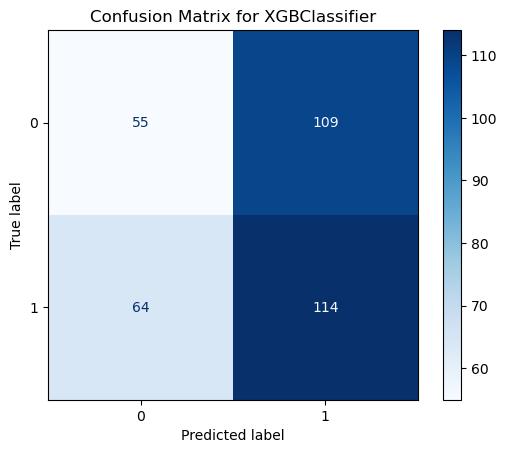

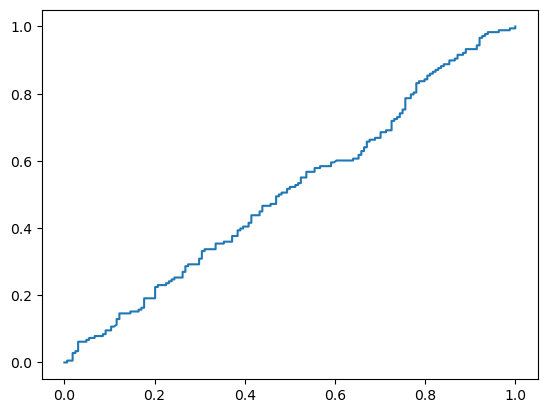

In [57]:
# Evaluate XGBClassifier
y_pred_xgb = xgb.predict(X_valid)
y_proba_xgb = xgb.predict_proba(X_valid)[:, 1]

print('XGBClassifier Evaluation:')
print('Training Accuracy:', metrics.roc_auc_score(Y_train, xgb.predict_proba(X_train)[:, 1]))
print('Validation Accuracy:', metrics.roc_auc_score(Y_valid, y_proba_xgb))
print('Classification Report:\n', classification_report(Y_valid, y_pred_xgb))

# Confusion Matrix
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(Y_valid, y_pred_xgb))
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBClassifier')
plt.show()

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(Y_valid, y_proba_xgb)
auc_xgb = roc_auc_score(Y_valid, y_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBClassifier ROC curve (area = {auc_xgb:.2f})')


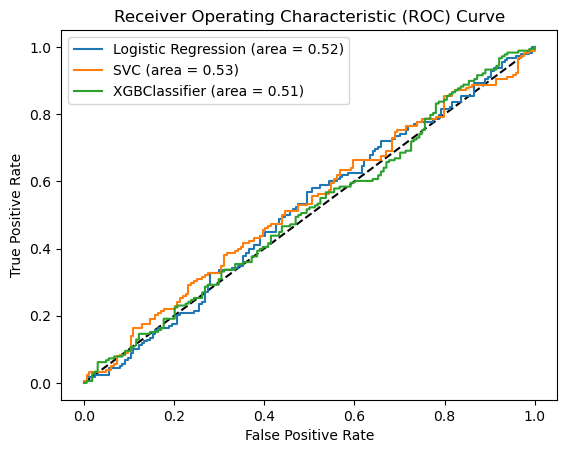

In [58]:
# Plot Final ROC Curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (area = {auc_log_reg:.2f})')
plt.plot(fpr_svc, tpr_svc, label=f'SVC (area = {auc_svc:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBClassifier (area = {auc_xgb:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()
